## 1. 환경 설정

`(1) Env 환경변수`

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [3]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

## 2. StateGraph
- 상태(state)를 기반으로 작동하는 그래프 구조
- 실습: 레스토랑 메뉴 추천 시스템
    - 사용자의 선호도에 따라 메뉴를 추천하고, 메뉴에 대한 정보를 제공

`(1) 상태(State)`
- 상태는 그래프가 처리하는 데이터의 구조를 정의
- 기존 상태를 override (덮어쓰기)

In [4]:
from typing import TypedDict

# 상태 Schema 정의 - 사용자의 선호도, 추천된 메뉴, 그리고 메뉴 정보를 저장
class MenuState(TypedDict):
    user_preference: str
    recommended_menu: str
    menu_info: str

`(2) 노드(Node)`
- 노드는 그래프에서 실제 작업을 수행하는 함수

In [5]:
import random

def get_user_preference(state: MenuState) -> MenuState:
    print("---랜덤 사용자 선호도 생성---")
    preferences = ["육류", "해산물", "채식", "아무거나"]
    preference = random.choice(preferences)
    print(f"생성된 선호도: {preference}")
    return {"user_preference": preference}

def recommend_menu(state: MenuState) -> MenuState:
    print("---메뉴 추천---")
    preference = state['user_preference']
    if preference == "육류":
        menu = "스테이크"
    elif preference == "해산물":
        menu = "랍스터 파스타"
    elif preference == "채식":
        menu = "그린 샐러드"
    else:
        menu = "오늘의 쉐프 특선"
    print(f"추천 메뉴: {menu}")
    return {"recommended_menu": menu}

def provide_menu_info(state: MenuState) -> MenuState:
    print("---메뉴 정보 제공---")
    menu = state['recommended_menu']
    if menu == "스테이크":
        info = "최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원"
    elif menu == "랍스터 파스타":
        info = "신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원"
    elif menu == "그린 샐러드":
        info = "신선한 유기농 채소로 만든 건강한 샐러드. 가격: 15,000원"
    else:
        info = "쉐프가 그날그날 엄선한 특별 요리입니다. 가격: 35,000원"
    print(f"메뉴 정보: {info}")
    return {"menu_info": info}

`(3) 그래프(Graph) 구성`
- 정의한 구성 요소들을 사용하여 전체 그래프를 빌드

In [6]:
from langgraph.graph import StateGraph, START, END

# 그래프 빌더 생성
builder = StateGraph(MenuState)

# 노드 추가
builder.add_node("get_preference", get_user_preference)
builder.add_node("recommend", recommend_menu)
builder.add_node("provide_info", provide_menu_info)

# 엣지 추가
builder.add_edge(START, "get_preference")
builder.add_edge("get_preference", "recommend")
builder.add_edge("recommend", "provide_info")
builder.add_edge("provide_info", END)

# 그래프 컴파일
graph = builder.compile()
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	get_preference(get_preference)
	recommend(recommend)
	provide_info(provide_info)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_preference;
	get_preference --> recommend;
	recommend --> provide_info;
	provide_info --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



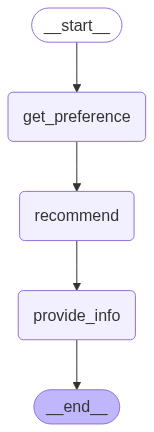

In [7]:
graph

In [8]:
# 그래프 실행

def print_result(result: MenuState):
    print("\n=== 결과 ===")
    print("선호도:", result['user_preference'])
    print("추천 메뉴:", result['recommended_menu'])
    print("메뉴 정보:", result['menu_info'])
    print("============\n")


# 초기 입려
inputs = {"user_preference": ""}

# 여러 번 실행하여 테스트 
for _ in range(2):
    result = graph.invoke(inputs)
    print_result(result)
    print("*"*100)
    print()

---랜덤 사용자 선호도 생성---
생성된 선호도: 육류
---메뉴 추천---
추천 메뉴: 스테이크
---메뉴 정보 제공---
메뉴 정보: 최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원

=== 결과 ===
선호도: 육류
추천 메뉴: 스테이크
메뉴 정보: 최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원

****************************************************************************************************

---랜덤 사용자 선호도 생성---
생성된 선호도: 해산물
---메뉴 추천---
추천 메뉴: 랍스터 파스타
---메뉴 정보 제공---
메뉴 정보: 신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원

=== 결과 ===
선호도: 해산물
추천 메뉴: 랍스터 파스타
메뉴 정보: 신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원

****************************************************************************************************



## 3. 조건부 엣지(Edge)
- 엣지는 노드 간의 연결을 정의
- 조건부 엣지: 사용자 입력이 메뉴 관련인지 여부에 따라 다른 경로로 진행

`(1) State 정의`
- 사용자 입력이 메뉴 추천이면 벡터저장소에서 검색하여 RAG Chain을 실행하고,
- 그렇지 않은 경우에는 LLM이 답변을 생성

In [9]:
from typing import List

# state 스키마 
class MenuState(TypedDict):
    user_query: str
    is_menu_related: bool
    search_results: List[str]
    final_answer: str

`(2) 벡터저장소 검색 도구`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [10]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

`(3) 노드(Node)`

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

def get_user_query(state: MenuState) -> MenuState:
    user_query = input("무엇을 도와드릴까요? ")
    return {"user_query": user_query}

def analyze_input(state: MenuState) -> MenuState:
    analyze_template = """
    사용자의 입력을 분석하여 레스토랑 메뉴 추천이나 음식 정보에 관한 질문인지 판단하세요.

    사용자 입력: {user_query}

    레스토랑 메뉴나 음식 정보에 관한 질문이면 "True", 아니면 "False"로 답변하세요.

    답변:
    """
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_menu_related = result.strip().lower() == "true"
    
    return {"is_menu_related": is_menu_related}

def search_menu_info(state: MenuState) -> MenuState:
    # 벡터저장소에서 최대 2개의 문서를 검색 
    results = vector_db.similarity_search(state['user_query'], k=2)
    search_results = [doc.page_content for doc in results]
    return {"search_results": search_results}

def generate_menu_response(state: MenuState) -> MenuState:
    response_template = """
    사용자 입력: {user_query}
    메뉴 관련 검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 메뉴 관련 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke({"user_query": state['user_query'], "search_results": state['search_results']})
    print(f"\n메뉴 어시스턴트: {final_answer}")
    
    return {"final_answer": final_answer}

def generate_general_response(state: MenuState) -> MenuState:
    response_template = """
    사용자 입력: {user_query}

    위 입력은 레스토랑 메뉴나 음식과 관련이 없습니다. 
    일반적인 대화 맥락에서 적절한 답변을 생성하세요.

    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke({"user_query": state['user_query']})
    print(f"\n일반 어시스턴트: {final_answer}")
    
    return {"final_answer": final_answer}

`(4) 엣지(Edge)`

In [12]:
from typing import Literal

def decide_next_step(state: MenuState) -> Literal["search_menu_info", "generate_general_response"]:
    if state['is_menu_related']:
        return "search_menu_info"  
    else:
        return "generate_general_response"

`(5) 그래프(Graph) 구성`

In [13]:
from langgraph.graph import StateGraph, START, END

# 그래프 구성
builder = StateGraph(MenuState)

# 노드 추가
builder.add_node("get_user_query", get_user_query)
builder.add_node("analyze_input", analyze_input)
builder.add_node("search_menu_info", search_menu_info)
builder.add_node("generate_menu_response", generate_menu_response)
builder.add_node("generate_general_response", generate_general_response)

# 엣지 추가
builder.add_edge(START, "get_user_query")
builder.add_edge("get_user_query", "analyze_input")

# 조건부 엣지 추가
builder.add_conditional_edges(
    "analyze_input",
    decide_next_step,
    {
        "search_menu_info": "search_menu_info",
        "generate_general_response": "generate_general_response"
    }
)

builder.add_edge("search_menu_info", "generate_menu_response")
builder.add_edge("generate_menu_response", END)
builder.add_edge("generate_general_response", END)

# 그래프 컴파일
graph = builder.compile()

In [14]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	get_user_query(get_user_query)
	analyze_input(analyze_input)
	search_menu_info(search_menu_info)
	generate_menu_response(generate_menu_response)
	generate_general_response(generate_general_response)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_user_query;
	analyze_input -.-> generate_general_response;
	analyze_input -.-> search_menu_info;
	get_user_query --> analyze_input;
	search_menu_info --> generate_menu_response;
	generate_general_response --> __end__;
	generate_menu_response --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



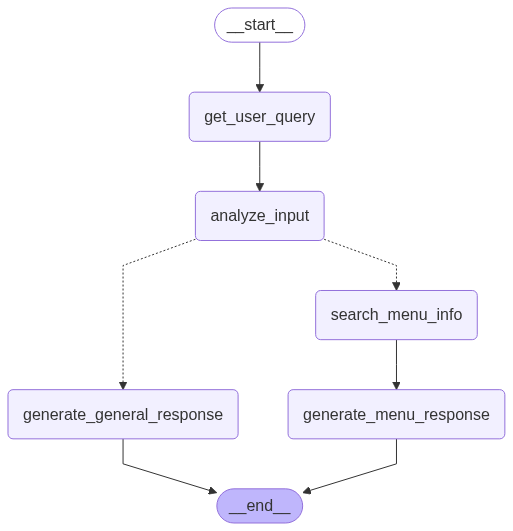

In [15]:
graph

`(6) Graph 실행`

In [16]:
while True:
    initial_state = {'user_query':''}
    graph.invoke(initial_state) 
    continue_chat = input("다른 질문이 있으신가요? (y/n): ").lower()
    if continue_chat != 'y':
        print("대화를 종료합니다. 감사합니다!")
        break

KeyboardInterrupt: Interrupted by user